In [26]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [27]:
import nest_asyncio
nest_asyncio.apply()

In [43]:
from pydantic import BaseModel
from playwright.async_api import Page
from typing import Literal, List, TypedDict, Annotated
from pydantic import Field
from operator import add




class Bbox(TypedDict):
    id: int
    x: float
    y: float
    type: str
    text: str
    arialabel: str

class ImageScreenShoot(TypedDict):
    img : str
    bboxes : List[Bbox]

class Action(TypedDict):
    action: Literal["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "press_enter"]
    text_to_type: str = Field(..., description="The text to be typed into the element if the action is type_text")
    bbox: Bbox
    description: str = Field(..., description="A short description of the action to be performed")

class AnswerNode(TypedDict):
    answer: str

class MasterPlanState(TypedDict):
    plan: List[str]

class CurrentPlanState(TypedDict):
    plan: List[str]

class ToolAndBboxActionList(TypedDict):
    tool_list: List[Action]

class AgentState(TypedDict):
    task: str
    page: Page
    master_plan: MasterPlanState
    current_plan: CurrentPlanState
    current_plan_executed: Annotated[List[str], add]
    tool_and_bbox_action: ToolAndBboxActionList
    last_tool_action: str
    next_tool_action: Action
    answer: AnswerNode
    notes: Annotated[List[str], add]
    status: Literal["in_progress", "completed"]


In [29]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io


with open("mark_page.js") as f:
    mark_page_script = f.read()

async def is_image_blank(image_bytes: bytes) -> bool:
    """Return True if the screenshot is fully blank (e.g. all white), else False."""
    if not image_bytes:
        return True
    img = PILImage.open(io.BytesIO(image_bytes)).convert("L")
    # If getbbox() returns None, the image is entirely one color
    return img.getbbox() is None

async def capture_screenshot(page: Page, max_retries=3, wait_seconds=2) -> bytes:
    """Take a screenshot, retry if blank (completely white)."""
    screenshot_bytes = b""
    for attempt in range(max_retries):
        # Wait for the page to be fully loaded
        await page.wait_for_load_state("networkidle")
        
        # Take screenshot
        screenshot_bytes = await page.screenshot()
        
        # Check if it's blank
        if not await is_image_blank(screenshot_bytes):
            return screenshot_bytes
        
        # If blank, wait a bit and retry
        print(f"[capture_screenshot] Screenshot is blank (attempt {attempt+1}/{max_retries}). Retrying...")
        await asyncio.sleep(wait_seconds)
    
    # If we get here, all attempts yielded a blank screenshot
    print("[capture_screenshot] All screenshot attempts were blank.")
    return screenshot_bytes  # Return whatever we got last


async def mark_page(page):

    """
    1. Wait for the page to be loaded using 'networkidle'.
    2. Attempt to run a 'mark_page_script' that presumably marks and returns bounding boxes.
    3. Retry up to 10 times if it fails.
    4. Capture a screenshot with retry logic (up to 3 tries) if the page is blank.
    5. Process screenshot (grayscale, resize, quantize, compress).
    6. Remove the markings before returning.
    """

    bboxes = List[Bbox]

    for attempt in range (10):
        try: 
            await page.wait_for_load_state("networkidle")

            await page.evaluate(mark_page_script)
            bboxes = await page.evaluate("markPage()")
            break
        except Exception as e:
            print(f"[mark_page] Attempt {attempt+1}/10 failed to mark page: {e}")
            asyncio.sleep(3)
    # Get screenshot as bytes
    await page.wait_for_load_state("networkidle")
    screenshot_bytes = await capture_screenshot(page, max_retries=3)
    
    # Process screenshot if we have any bytes
    if screenshot_bytes:
        img = PILImage.open(io.BytesIO(screenshot_bytes))
        # Convert to grayscale
        img = img.convert('L')
        # Resize
        max_size = (300, 300)
        img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
        # Quantize and convert back to grayscale
        img = img.quantize(colors=16).convert('L')
        
        # Compress
        buffer = io.BytesIO()
        img.save(
            buffer,
            format='JPEG',
            quality=5,      # Low quality -> smaller size
            optimize=True,
            progressive=True
        )
        compressed_bytes = buffer.getvalue()
    else:
        # If screenshot is empty or never taken, handle gracefully
        print("[mark_page] Using empty screenshot due to failure or blank screenshot.")
        compressed_bytes = b""

    await page.wait_for_load_state("networkidle")
    try:
        await page.evaluate("unmarkPage()")
    except Exception as e:
        print(f"[mark_page] Could not unmark page: {e}")

    # Build final result
    return ImageScreenShoot(
        img=base64.b64encode(compressed_bytes).decode("utf-8"),
        bboxes=bboxes
    )



In [30]:
from langchain_core.tools import Tool
from langchain_core.tools import StructuredTool
from langchain_core.messages import AIMessage, HumanMessage
import platform
from pprint import pprint

async def click_element(agent_state: AgentState):
    """Click on a specified element on the webpage using its bounding box coordinates.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    """
    print("********************CLICK ELEMENT TOOL********************\n")

    page = agent_state["page"]
    
    next_tool_action = agent_state["next_tool_action"]
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(next_tool_action)
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
   
    await page.mouse.click(bbox["x"], bbox["y"])
    await page.wait_for_load_state("domcontentloaded")

    bbox_text = bbox["text"]
    bbox_id = bbox["id"]    
    description = next_tool_action["description"]
    return { "last_tool_action": f"{description}. (clicked element with id {bbox_id} and text {bbox_text})"} # Return string, not dict


async def scroll_element(agent_state: AgentState):
    """Scroll the webpage up or down.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
   
    """
    print("********************SCROLL TOOL********************\n")
 
    page = agent_state["page"]
    next_tool_action = agent_state["next_tool_action"]
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(next_tool_action)
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
    await page.mouse.wheel(0, 200)
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    await page.wait_for_load_state("domcontentloaded")
    description = next_tool_action["description"]
    return {"last_tool_action": f"{description}. (scrolled element with id {bbox_id} and text {bbox_text})"} # Return string, not dict


async def type_text(agent_state: AgentState):
    """Type text into a specified element on the webpage.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    
    """
    print("********************TYPE TEXT TOOL********************\n")

    page = agent_state["page"]

    next_tool_action = agent_state["next_tool_action"]
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(next_tool_action)
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(next_tool_action["text_to_type"])
    await page.wait_for_load_state("domcontentloaded")
    description = next_tool_action["description"]
    return {"last_tool_action": f"{description}. (typed text into element with id {bbox_id} and text {bbox_text})"} # Return string, not dict


async def wait(agent_state: AgentState):
    print("********************WAIT NODE********************\n")

    sleep_time = 5
    await asyncio.sleep(sleep_time) 
    next_tool_action = agent_state["next_tool_action"]
    description = next_tool_action["description"]
    return {"last_tool_action": f"{description}. (waited for {sleep_time} seconds)"} # Return string, not dict

async def go_back(agent_state: AgentState):
    print("********************GO BACK NODE********************\n")

    await agent_state["page"].go_back()
    await agent_state["page"].wait_for_load_state("domcontentloaded")
    next_tool_action = agent_state["next_tool_action"]  
    description = next_tool_action["description"]
    return { "last_tool_action": f"{description}. (went back to the previous page)"} # Return string, not dict

async def go_to_google(agent_state: AgentState):
    print("********************GO TO GOOGLE NODE********************\n")

    next_tool_action = agent_state["next_tool_action"]
    description = next_tool_action["description"]   
    await agent_state["page"].goto("https://www.google.com")
    await agent_state["page"].wait_for_load_state("domcontentloaded")
    return {"last_tool_action": f"{description}. (went to google)"} # Return string, not dict

async def press_enter(agent_state: AgentState):
    print("********************PRESS ENTER NODE********************\n")
    
    next_tool_action = agent_state["next_tool_action"]

    description = next_tool_action["description"]   
    await agent_state["page"].keyboard.press("Enter")
    await agent_state["page"].wait_for_load_state("domcontentloaded")
    return {"last_tool_action": f"{description}. (pressed enter)"} # Return string, not dict


In [44]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

async def master_plan_node(state: AgentState):
    print("********************MASTER PLAN NODE********************\n")

    screen_shot = await mark_page(state["page"])
    

    system_message = """
    You are an expert a preparing a step by step plan to complete a task.
    You will be given a task provided by the user. The task might also be a question.
    You will need to prepare a plan to complete the task. In case its a question, you will need to prepare a plan to answer the question.
    Also in the response indicate weather the current page is a search engine home page or not.

    You will be also provided the screenshot of the current web page.
    - If the current page is google home page or any other search engine, create a plan that basically searches the keyword and continues to the next step.
    - If the current page is not a some other web page, create a plan to scroll through the page and relevant collect information. 

    For eg if the task is "What is the lastest news on Apple's stock price?", you will need to prepare a plan to answer the question.
    You will need to prepare a plan to complete the task.

    For example, if the task is "What is the latest news on Apple's stock price?", your plan might look like this:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    Your plan should be clear, sequential, and focused on achieving the user's goal efficiently. 

    --Notes--
    The browser is already open.
    For any question, you will need to go to google and search for the question.
    """ 

    human_prompt = """ This is the task that needs to be performed/question that needs to be answered: {task} \n This is the screenshot of the current web page: {screenshot}"""

    task = state["task"]

    human_message = human_prompt.format(task=task, screenshot=screen_shot)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]
    structured_llm = llm.with_structured_output(MasterPlanState)

    response = structured_llm.invoke(messages)
    
    print("----------------------------------------------------------\n")
    print("Master Plan:")
    pprint(response)
    print("----------------------------------------------------------\n")

    return {"master_plan": [response], "status": "in_progress"}



In [54]:
async def current_plan_node(state: AgentState):
    
    print("********************CURRENT PLAN NODE********************\n")

    
    screen_shot = await mark_page(state["page"])

   
    system_message = """ 
    You are an helpful assistant that can take in a broader master plan and create extract a subset of steps  which will be the current plan.
   
    To create the current plan, you will be given :
    - the master plan
    - a screenshot of the current web page
    - the current plan that has been executed so far (if any)

    Notes:
    - The subset of steps that you extract for the current plan should be strictly restricted to the steps that can performed on the current web page whose screenshot is provided.
    - If certain steps of the master plan have already been completed, which will be provided to you as the current plan that has been executed so far, extract the next subset of the steps from master plan that can be performed on the current web page whose screenshot is provided.
    - The current plan you extract should be a subset of the master plan.
    - Make sure to create a current plan that is as atomic as possible for the current web page. 
    
    For eg if the master plan is:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Scroll through the results page and click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    If the screenshot of the current web page is a search engine home page, thr current plan should be:
    1. Click on the search bar
    2. Type "Apple stock price news today"
    3. Press enter

    If the above mentioned steps are already completed and a search engine results page is shown, the updated current plan you should return is:
    1. Scroll down the page to find the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    2. Click on one of the link


    If the screenshot is of a some other web page, the current plan should be:
    1. Scroll down the page and collect relevant information.

    Very important: 
    Irrespective of the current page being a search engine home page or not:
    Before deciding which page to go to, you need to scroll through the current page and collect information
    For eg:
         - If the current page is a if its an article/ finance/ news page or anything else apart from a search engine home page, you need to scroll through the page and collect information.
         - If the current page is a search engine results page, you need to scroll through the page and before deciding which page to go to, and collect information.
   
    Think of how a human would surf the web to complete the task.
    """

    human_prompt = """ 
    This is the master plan : {master_plan}
    This is the screenshot of the current web page: {screenshot}
    This is the current plan that has been executed so far: {current_plan}
    """

    master_plan = state["master_plan"]
    current_plan = state["current_plan"]
    print(master_plan)
    human_message = human_prompt.format(master_plan=master_plan, screenshot=screen_shot, current_plan=current_plan)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]

    print(messages)
    
    structured_llm = llm.with_structured_output(CurrentPlanState)
    response = structured_llm.invoke(messages)
    print("----------------------------------------------------------\n")
    print("Current Plan:")
    pprint(response)
    print("----------------------------------------------------------\n")

    return {"current_plan": [response], "status": "in_progress"}


In [55]:
async def current_plan_executables_node(state: AgentState):
    print("********************EXECUTE CURRENT PLAN NODE********************\n")

    current_plan = state["current_plan"]

    screen_shot = await mark_page(state["page"])
    
    system_prompt = """ 
    You are an expert at executing a plan on a web page.
    You will be given -
    1. A plan to be executed on a web page.
    2. A screenshot of the current web page with a list of bounding boxes of the elements on the page containing the text of the elements, their id, and their arialabel, x, y coordinates.

    
    You are supposed to review the plan and the screenshot and execute the steps in the plan by calling appropriate tools.

    The tools you have are - 
    1. click_element - click on a specified element on the webpage using its bounding box coordinates.
    2. scroll_element - scroll the webpage up or down.
    3. type_text - type text into a specified element on the webpage.
    4. wait - wait for a specified amount of time.
    5. go_back - go back to the previous page.
    6. go_to_google - go to google.
    7. press_enter - press enter.
    
    Convert the current plan into a list of actions that can be performed on the web page the format of the action is - 
    {
        "action": "click_element",
        "text_to_type": "Apple stock price news today", # This is the text that needs to be typed into the element such as search bar if needed
        "bbox": {
            "id": 1,
            "x": 100,
            "y": 100, 
            "text": "Apple stock price news today",
            "arialabel": "Apple stock price news today"
        }
    }

    Note: Think from a machine's perspective. For eg if google home page appears, before you can type anything in the search bar, you need to click on it.
    For every action that needs to be performed, break it down into the most atomic steps as possible. using the tools provided.

    """

    human_prompt = """ 
    This is the current plan: {current_plan}
    This is the screenshot of the current web page: {screenshot}
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(current_plan=current_plan, screenshot=screen_shot))
    ]   

    structured_llm = llm.with_structured_output(ToolAndBboxActionList)
    response = structured_llm.invoke(messages)
    print("----------------------------------------------------------\n")
    print("Tool and Bbox Action List:")
    pprint(response)
    print("----------------------------------------------------------\n")

    return {"tool_and_bbox_action": response, "status": "in_progress"}


In [56]:
from langgraph.graph import StateGraph, START, END

async def tool_router_node(state: AgentState):
    print("********************SHOULD CALL TOOL NODE********************\n")


    system_prompt = """ 
    You will be given a list of actions that can be performed on the web page.
    Based on the last tool action, you need to determine  which action needs to be performed from the list of actions.

    If all tool actions are completed, return FINISHED.
    """

    human_prompt = """ 
    This is the list of actions that can be performed on the web page: {tool_and_bbox_action}
    This is the last tool action: {last_tool_action}
    """
    tool_and_bbox_action = state["tool_and_bbox_action"]
    last_tool_action = state["last_tool_action"]

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(tool_and_bbox_action=tool_and_bbox_action, last_tool_action=last_tool_action))
    ]

    structured_llm = llm.with_structured_output(Action)
    response = structured_llm.invoke(messages)
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(response)
    print("----------------------------------------------------------\n")

    return {"next_tool_action": response, "status": "in_progress"}


async def should_call_tool(state: AgentState):
    next_tool_action = state["next_tool_action"]
    next_tool_action_type = next_tool_action["action"]

    if next_tool_action_type == "click_element":
        return "click_element"
    elif next_tool_action_type == "scroll_element":
        return "scroll_element"
    elif next_tool_action_type == "type_text":
        return "type_text"
    elif next_tool_action_type == "wait":
        return "wait"
    elif next_tool_action_type == "go_back":
        return "go_back"
    elif next_tool_action_type == "go_to_google":
        return "go_to_google"
    elif next_tool_action_type == "press_enter":
        return "press_enter"
    elif next_tool_action_type == "FINISHED":
        return "self_review"
    else:
        ValueError(f"Invalid action: {next_tool_action_type}")



In [57]:
async def update_notes_node(state: AgentState):
    print("********************UPDATE NOTES NODE********************\n")

    screen_shot = await mark_page(state["page"])
    task = state["task"]
    system_prompt = """ 
    You are an expert at taking down notes from a web page.
    You will be given a screenshot of the current web page and the task that needs to be performed/question that needs to be answered to by completing a task for the user.

    Based on the task provided, try to analyze the relevant information from the screenshot of the web page and take down notes.

    If you are not able to find any relevant information, return "NO_NOTES".

    """

    human_prompt = """ 
    This is the screenshot of the current web page: {screenshot}
    This is the task that needs to be performed/question that needs to be answered: {task}
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(screenshot=screen_shot, task=task))
    ]

    response = llm.invoke(messages)

    print("----------------------------------------------------------\n")
    print("Notes:")
    pprint(response)
    print("----------------------------------------------------------\n")

    if response.content == "NO_NOTES":
        return {"notes": [], "status": "in_progress"}
    else:
        return {"notes": [response.content], "status": "in_progress"}


In [58]:
async def self_review_node(state: AgentState):
    print("********************SELF REVIEW NODE********************\n")


    system_prompt = """ 
    You are an expert at reviewing the notes taken and analyzing the information to determine if the task has been completed or user's question has been answered.
    If you have enough information to answer the question, return "FINISHED".
    If you do not have enough information, return "CONTINUE".
    """

    human_prompt = """ 
    This is the notes taken: {notes}
    This is the task that needs to be performed/question that needs to be answered: {task}
    """

    notes = state["notes"]
    task = state["task"]

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(notes=notes, task=task))
    ]

    response = llm.invoke(messages)
    
    print("----------------------------------------------------------\n")
    print("Self Review:")
    pprint(response)
    print("----------------------------------------------------------\n")
    current_plan = state["current_plan"]


    if response.content == "FINISHED":
        return {"status": "completed", "current_plan_executed": current_plan}
    else:
        return {"status": "in_progress", "current_plan_executed": current_plan}
    
async def should_answer(state: AgentState):
    status = state["status"]
    print("********************SHOULD ANSWER NODE********************\n")
    print("----------------------------------------------------------\n")
    print("Status:")
    pprint(status)
    print("----------------------------------------------------------\n")

    if status == "completed":
        return "answer_node"
    else:
        return "current_plan_node"


In [59]:
async def answer_node(state: AgentState):
    print("********************ANSWER NODE********************\n")
    
    system_prompt = """ 
    You are an expert at answering a question.
    You will be given:
     -  a question that needs to be answered or a task that needs to be completed for the user 
     -  the notes taken while surfing the web related to the question or task
     

    Answer the question based on the information provided or provide task completion status based on the information provided in the notes.

    A few instructios:
    - Format the answer in markdown format.
    - Use proper markdown formatting for the answer, bullets, headings, etc.
    - Keep it concise and to the point.
    """

    human_prompt = """ 
    This is the question that needs to be answered: {task}
    This is the notes taken: {notes}
    """

    task = state["task"]
    notes = state["notes"]

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(task=task, notes=notes))
    ]

    response = llm.invoke(messages)
    
    print("----------------------------------------------------------\n")
    print("Answer:")
    pprint(response.content)
    print("----------------------------------------------------------\n")

    return {"answer": response.content, "status": "completed"}


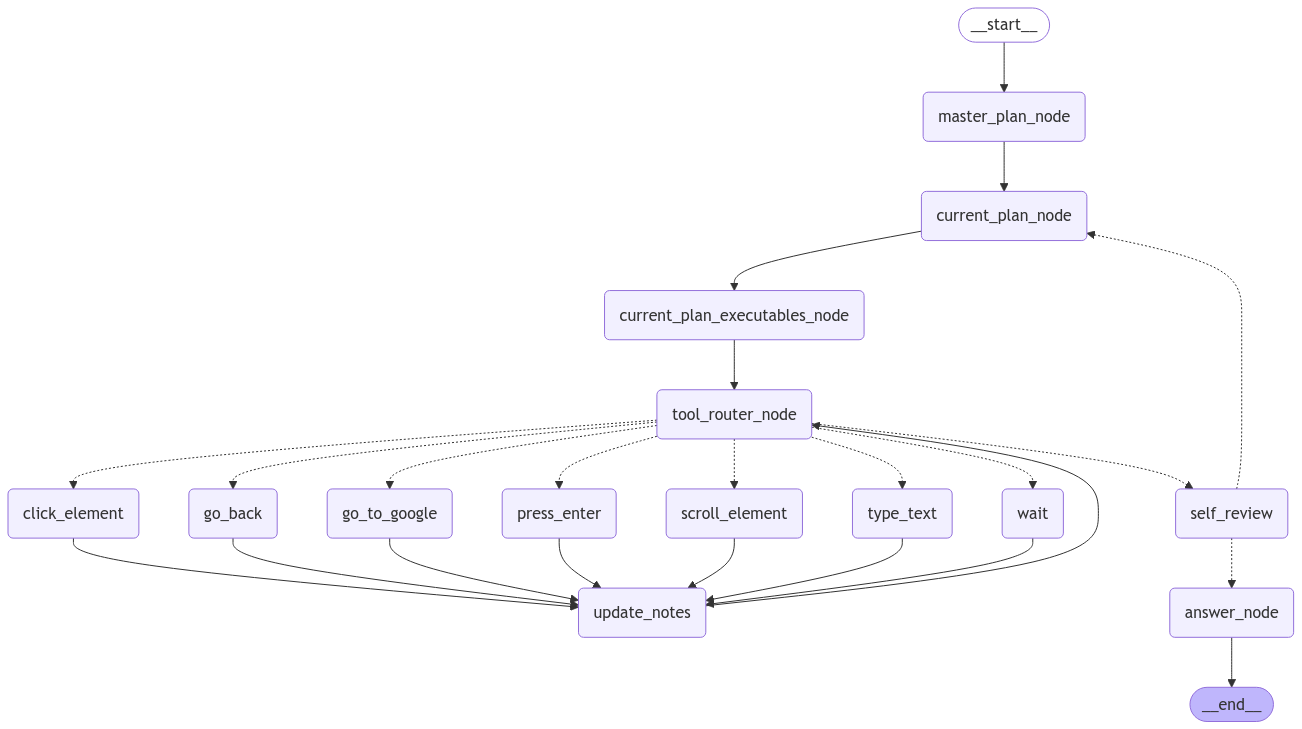

In [60]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END



builder = StateGraph(AgentState)

builder.add_node("master_plan_node", master_plan_node)
builder.add_node("current_plan_node", current_plan_node)
builder.add_node("current_plan_executables_node", current_plan_executables_node) 
builder.add_node("tool_router_node", tool_router_node)
builder.add_node("click_element", click_element)
builder.add_node("scroll_element", scroll_element)
builder.add_node("type_text", type_text)
builder.add_node("wait", wait)
builder.add_node("go_back", go_back)
builder.add_node("go_to_google", go_to_google)
builder.add_node("press_enter", press_enter)
builder.add_node("update_notes", update_notes_node)
builder.add_node("self_review", self_review_node)
builder.add_node("answer_node", answer_node)


builder.add_edge(START, "master_plan_node")
builder.add_edge("master_plan_node", "current_plan_node")
builder.add_edge("current_plan_node", "current_plan_executables_node")
builder.add_edge("current_plan_executables_node", "tool_router_node")
builder.add_conditional_edges("tool_router_node", should_call_tool, ["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "press_enter", "self_review"])

builder.add_edge("click_element", "update_notes")
builder.add_edge("scroll_element", "update_notes")
builder.add_edge("type_text", "update_notes")
builder.add_edge("wait", "update_notes")
builder.add_edge("go_back", "update_notes")
builder.add_edge("go_to_google", "update_notes")
builder.add_edge("press_enter", "update_notes")
builder.add_edge("update_notes", "tool_router_node")
builder.add_conditional_edges("self_review", should_answer, ["answer_node", "current_plan_node"])
builder.add_edge("answer_node", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
async def setup_browser(go_to_page: str):
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    page = await browser.new_page()
    try:
        # Increase timeout to 80 seconds and add wait_until option
        await page.goto(go_to_page, timeout=80000, wait_until="domcontentloaded")
    except Exception as e:
        print(f"Error loading page: {e}")
        # Fallback to Google if the original page fails to load
        await page.goto("https://www.google.com", timeout=60000, wait_until="domcontentloaded")
    return playwright, browser, page

config = {
        "configurable": {"thread_id": "1"},
    }


async def call_agent(task: str, go_to_page: str, max_steps: int = 250):
    playwright, browser, page = await setup_browser(go_to_page)
    final_answer = None

    try:
        result = await graph.ainvoke(
            {
                "task": task, 
                "page": page, 
                "last_tool_action": "",
                "current_plan_executed": [],
                "status": "in_progress",
                "master_plan": [],
                "current_plan": [],
                "notes": []
            }, 
            {"recursion_limit": 400}
            
        )
    finally:
        await browser.close()
        await playwright.stop()

    return result
    

task = "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown."
go_to_page = "https://www.google.com"

final_answer = await call_agent(task, go_to_page)




********************MASTER PLAN NODE********************

----------------------------------------------------------

Master Plan:
{'plan': ["Go to Google Maps by typing 'Google Maps' in the search bar and "
          'pressing enter.',
          'Click on the Google Maps link to open the application.',
          "In the search bar of Google Maps, enter 'San Francisco Downtown' as "
          'the starting point.',
          "Enter 'San Francisco International Airport (SFO)' as the "
          'destination.',
          'Set the arrival time to 7:00 AM in the options to get the '
          'recommended departure time.',
          'Review the suggested departure time and any traffic conditions that '
          'might affect the travel time.',
          'Note down the time you need to leave to reach SFO by 7:00 AM.']}
----------------------------------------------------------

********************CURRENT PLAN NODE********************

[{'plan': ["Go to Google Maps by typing 'Google Maps' 

/var/folders/3g/r3ht76p907vdqxh325xx85tm0000ks/T/ipykernel_10912/1175683594.py:65: RuntimeWarning: coroutine 'sleep' was never awaited
  asyncio.sleep(3)


[mark_page] Attempt 2/10 failed to mark page: Page.evaluate: Execution context was destroyed, most likely because of a navigation
----------------------------------------------------------

Notes:
AIMessage(content='NO_NOTES', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 2700, 'total_tokens': 2704, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-cc318f88-8aed-4fdd-ae89-1cbd71841ac7-0', usage_metadata={'input_tokens': 2700, 'output_tokens': 4, 'total_tokens': 2704, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})
----------------------------------------------------------

**********

/var/folders/3g/r3ht76p907vdqxh325xx85tm0000ks/T/ipykernel_10912/1175683594.py:65: RuntimeWarning: coroutine 'sleep' was never awaited
  asyncio.sleep(3)


----------------------------------------------------------

Notes:
AIMessage(content='NO_NOTES', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 1752, 'total_tokens': 1756, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-f50a26c7-6584-40ae-8c96-ed99bc79bbd6-0', usage_metadata={'input_tokens': 1752, 'output_tokens': 4, 'total_tokens': 1756, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})
----------------------------------------------------------

********************SHOULD CALL TOOL NODE********************

----------------------------------------------------------

Next Tool Action:

CancelledError: 